In [15]:

import json
import numpy as np
import pandas as pd
# 汇总为DataFrame
data = {}
json_file = 'model_metrics.json'
with open(json_file, 'r') as f:
    data = json.load(f)
arima_mape, lstm_mape, gnn_mape, transformer_mape = data['ARIMA']['MAPE'], data['LSTM']['MAPE'], data['GNN']['MAPE'], data['Transformer']['MAPE']
arima_mse, lstm_mse, gnn_mse, transformer_mse = data['ARIMA']['MSE'], data['LSTM']['MSE'], data['GNN']['MSE'], data['Transformer']['MSE']
    
result = []
for method, metrics in data.items():
    mse = metrics['MSE']
    mape = metrics['MAPE']
    mse_acc = 1 - np.mean(mse) / (np.mean(mse) + 1e-8)
    mape_acc = 1 - np.mean(mape) / 100
    result.append({
        'Method': method,
        'MSE_mean': np.mean(mse),
        'MSE_median': np.median(mse),
        'MSE_std': np.std(mse),
        'MSE_95th': np.percentile(mse, 95),
        'MAPE_mean': np.mean(mape),
        'MAPE_median': np.median(mape),
        'MAPE_std': np.std(mape),
        'MAPE_95th': np.percentile(mape, 95),
        'MSE_Accuracy': mse_acc,
        'MAPE_Accuracy': mape_acc
    })

df_result = pd.DataFrame(result)
print(df_result)


        Method   MSE_mean  MSE_median   MSE_std   MSE_95th  MAPE_mean  \
0        ARIMA  12.919478   12.930863  1.433961  15.178056   1.589265   
1         LSTM   0.021744    0.022019  0.002188   0.025264   0.254722   
2          GNN   0.029527    0.029346  0.002602   0.033275   0.410858   
3  Transformer   0.021271    0.021085  0.002014   0.024731   0.286775   

   MAPE_median  MAPE_std  MAPE_95th  MSE_Accuracy  MAPE_Accuracy  
0     1.601209  0.138090   1.810569  7.740252e-10       0.984107  
1     0.253629  0.025900   0.299179  4.598999e-07       0.997453  
2     0.414415  0.042010   0.483158  3.386726e-07       0.995891  
3     0.286217  0.027223   0.329472  4.701317e-07       0.997132  


/tmp/ipykernel_1697798/3576319456.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


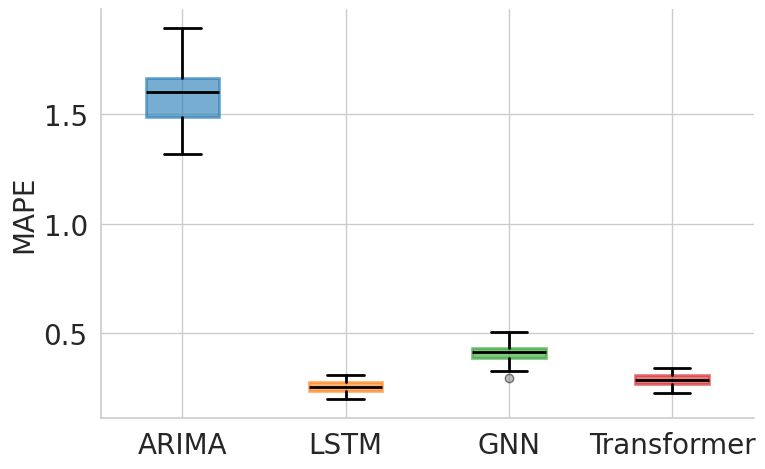

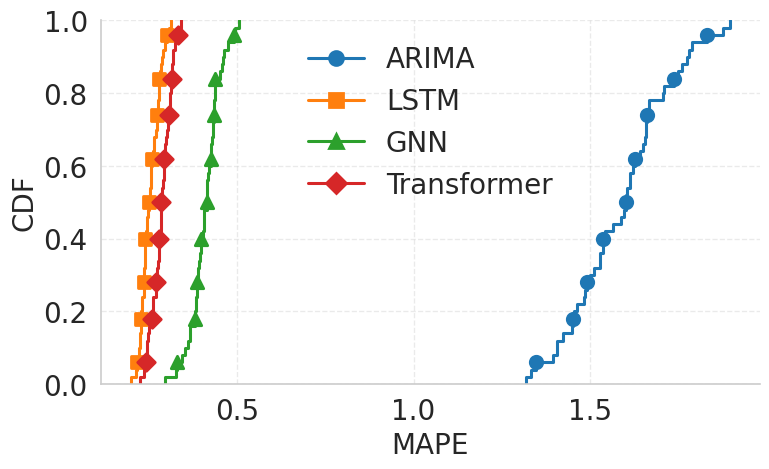

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.lines as mlines

# 配色方案
SIGCOMM_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
LABELS = ['ARIMA', 'LSTM', 'GNN', 'Transformer']
MARKERS = ['o', 's', '^', 'D']

sns.set(style='whitegrid', font_scale=1.4)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.2

# --- 1. 箱线图 ---
fig, ax = plt.subplots(figsize=(8, 5))

box = ax.boxplot(
    [arima_mape, lstm_mape, gnn_mape, transformer_mape],
    patch_artist=True,
    labels=LABELS,
    medianprops=dict(color='black', linewidth=2),
    boxprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2),
    flierprops=dict(marker='o', markersize=6, markerfacecolor='grey', alpha=0.5)
)
for patch, color in zip(box['boxes'], SIGCOMM_COLORS):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
    patch.set_edgecolor(color)

ax.set_ylabel('MAPE', fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig('result/fig-mape_boxplot.pdf', bbox_inches='tight')
plt.show()

# --- 2. CDF 曲线 ---
plt.figure(figsize=(8, 5))

data_list = [arima_mape, lstm_mape, gnn_mape, transformer_mape]
legend_handles = []

for idx, (data, label, color, marker) in enumerate(zip(data_list, LABELS, SIGCOMM_COLORS, MARKERS)):
    # 绘制CDF曲线
    sns.ecdfplot(data, color=color, linewidth=2.2)
    # 计算marker点位置（等分9个分位点）
    values = np.sort(np.array(data))
    n = len(values)
    cdf_y = np.arange(1, n + 1) / n
    quantiles = np.linspace(0.05, 0.95, 9)
    marker_x = []
    marker_y = []
    for q in quantiles:
        idx_q = np.searchsorted(cdf_y, q)
        idx_q = min(idx_q, n-1)
        marker_x.append(values[idx_q])
        marker_y.append(cdf_y[idx_q])
    plt.scatter(marker_x, marker_y,
                facecolors=color,
                edgecolors=color,
                marker=marker,
                s=80,
                linewidths=2,
                zorder=10)

    # 构造带marker的legend句柄
    handle = mlines.Line2D([], [], 
                           color=color,
                           marker=marker,
                           linestyle='-',
                           linewidth=2.2,
                           markersize=10,
                           markerfacecolor=color,
                           markeredgewidth=2,
                           markeredgecolor=color,
                           label=label)
    legend_handles.append(handle)

plt.xlabel('MAPE', fontsize=20)
plt.ylabel('CDF', fontsize=20)
plt.legend(handles=legend_handles, fontsize=20, frameon=False)
plt.grid(True, linestyle='--', linewidth=1, alpha=0.4)
plt.tick_params(axis='both', labelsize=20)
sns.despine()

plt.tight_layout()
plt.savefig('result/fig-mape_cdf.pdf', bbox_inches='tight')
plt.show()